<a href="https://colab.research.google.com/github/Tamrika/Deep-Learning/blob/main/time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Time Series Prediction Using Recurrent Neural Network</center>

This notebook demonstrates the application of recurrent neural networks in solving sequence prediction problem. 

We will be working with the weather forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We first start with a simple non-recurrent fully connected network as a benchmark. Then we create our first baseline recurrent model improve it using drop out regularization, bidirectional connections, and stacking more recurrent layers.  

The materials covered in this lab are mostly from "Deep Learning with Python" book by Francois Chollet, chapter 6, section 3 and this [tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) 

Before proceeding, at the top menu of this colab notebook select Runtime-->change runtime type--->GPU to seepd up running the code segments in the notebook.

## A temperature forecasting problem
The weather dataset used in this lab is collected by  the Max Planck Institute for Biogeochemistry.
This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

Let's import the libraries we need and download the data into your colab session.


In [ ]:
!pip install pandas
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
df = pd.read_csv(zip_path)


13574144/13568290 [==============================] - 0s 0us/step


Let's take a look at the few records in the data:

In [ ]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


## Preparing data for Machine Learning


### Data Cleaning

The data is recorded in ten minutes intervals (rows are 10 minutes apart). We want to do **hourly prediction**, that is, we want to predict the temprature in the next hour given the previous hours. So we subsample data from 10 minutes intervals to one hour intervals by taking every 6 records starting from index 5.



In [ ]:
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

#take a look at the summary statistics of each column
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [ ]:
#replacing -9999 with 0 in wv column
wv= df['wv (m/s)']
df.loc[wv==-9999.00, 'wv (m/s)']=0

#replacing -9999 with 0 in mwv column
mwv=df['max. wv (m/s)']
df.loc[mwv==-9999.00,'max. wv (m/s)']=0

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### Feature Engineering
There are a couple features that need further treatment.  The last column of the data, wd (deg), gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 
The [tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) does a couple useful feature engineering on the wind direction and its velacity. The wind forms a vector ( the direction is the angle and the velocity is the magnitude of the vector). We can convert this vector to its X and Y. We can get the x and y coordinates by multiplying the velocity by the cosine and sine of the wind radians respectively.  This conversion will make the distance between the wind vectors meaningful for the model.

We can ndo this as follows:

In [ ]:
#removing the wind velocity (wv (m/s)) and max wind velocity (max. wv (m/s))
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# remove the wind degree column and convert it to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components of the wind vector.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components of the max wind vector.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Another useful feature engineering suggested by tensorflow is to convert the date time to time of the day and time of the year. These two features are intuitively more predictive of the temprature than the absolute date/time value.

Since the weather data has clear daily and yearly periodicity, we can look at day and year as  unit circles and then model the time of day and day of the year as a vector in that circle. similar to the wind feature, we can use sin and cosine to get the x and y components of the time vector.

The following code segment first converts the time stamp to the seconds. 
It then divides the time stamp by the number of seconds in a day and the number of seconds in a year and  multiply them by $2\pi$ to get the radians for the time of day and day of year vectors. Finally it takes the sin and cosine of the radians to compute the x and y components for each vector (similar to what we did for the wind)

converting the time stamp this way captures the daily and yearly periodicity of the temprature.



In [ ]:
#convert date time from string to datetime object. 
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

#get the time stamp in seconds
timestamp_seconds = date_time.astype('int64') // 10**9

# compute the number of seconds in a day and year
seconds_in_a_day= 24*60*60
seconds_in_a_year=(365.2425)*seconds_in_a_day

#conver the timestamp to time of day and time of year x and y components
df['Day y'] = np.sin(timestamp_seconds * (2 * np.pi / seconds_in_a_day))
df['Day x'] = np.cos(timestamp_seconds * (2 * np.pi / seconds_in_a_day))
df['Year y'] = np.sin(timestamp_seconds * (2 * np.pi / seconds_in_a_year))
df['Year x'] = np.cos(timestamp_seconds * (2 * np.pi / seconds_in_a_year))

#let's look at the data again
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.600000,984.200000,9.895700e+02,994.720000,1015.290000
T (degC),70091.0,9.450482,8.423384,-22.760000,3.350000,9.410000e+00,15.480000,37.280000
Tpot (K),70091.0,283.493086,8.504424,250.850000,277.440000,2.834600e+02,289.530000,311.210000
Tdew (degC),70091.0,4.956471,6.730081,-24.800000,0.240000,5.210000e+00,10.080000,23.060000
rh (%),70091.0,76.009788,16.474920,13.880000,65.210000,7.930000e+01,89.400000,100.000000
VPmax (mbar),70091.0,13.576576,7.739883,0.970000,7.770000,1.182000e+01,17.610000,63.770000
VPact (mbar),70091.0,9.533968,4.183658,0.810000,6.220000,8.860000e+00,12.360000,28.250000
VPdef (mbar),70091.0,4.042536,4.898549,0.000000,0.870000,2.190000e+00,5.300000,46.010000
sh (g/kg),70091.0,6.022560,2.655812,0.510000,3.920000,5.590000e+00,7.800000,18.070000
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.810000,6.290000,8.960000e+00,12.490000,28.740000


### Split and Normalize
Let's split and normalize the data. 

When splitting time series data, we should maintain the order of the sequence. this is typically done by taking first n records as trianing, the next m records as validation and the last k records for testing. 

Splitting this way does not distort the sequential order in the samples and ensures that the validation/test results are more realistic, being evaluated on data collected afte[link text](https://)r the model was trained.

let's ake the first 70% of data for training, the next 20% samples for validation, and the last 10% samples for testing.

In [ ]:
#get the number of samples
n = len(df)

# use,  the first 70% of samples for training
train = df[0:int(n*0.7)]

#use the next 20% of samples for testing
val = df[int(n*0.7):int(n*0.9)]

#use the last 10% of samples for testing
test = df[int(n*0.9):]

print("train shape", train.shape)
print("validation shape", val.shape)
print("test shape", test.shape)

train shape (49063, 19)
validation shape (14018, 19)
test shape (7010, 19)


As always, we need to scale the features before training a neural network model. Note that the validation and test sets are normalized based on the statistics (mean and std) computed from the training data

In [ ]:
train_mean = train.mean()
train_std = train.std()

train_df = (train - train_mean) / train_std
val_df = (val - train_mean) / train_std
test_df = (test - train_mean) / train_std

### Data Windowing: Preparing Data for Supervised Learning
In a time series prediction data, we typically want to make a set of predictions based on a window of consecutive samples in the data.  The main feature of the window are:
* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both.
For example, to make a single prediction 24 time steps into the future, given 24 time steps of history we might define a window like this:


![window](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)


For the temprature prediction problem, we want to predict the temprature 24 hours in the future. Suppose that the sample at time step $t_0$  (the first row in the data) is $s_0$ and we have 49063 hourly samples in our training data. We can convert this problem to a supervised learning problem by creating windows/data samples of the following form:

$input= (s_0 , s_1, ...,s_{24})$    $output=t_{48}$  where $t_{48}$ is the temprature at time step 48 (that is the temprature column in row 48 of the data)
The next input/output pairs would be:
$input=(s_1,s_2,...,s_{25})$, $output=t_{49}$

$input=(s_2,s_3,...,s_{26})$, $output=t_{50}$

and so on until

$input=(s_{49015}, s_{49016},....,s_{49039}$, output=t_{49063}

As you can see we slide the window to the right by one row to create the next input/output pairs.

Let's  define a simple python generator, we call it <code>windowGenerator</code>, that takes the following parameters and creates batches of input/output pairs in the above form. We can then feed these batches as input to our neural network models.

* <code> data</code>: An array of sequential data where rows are consecutive data points and columns are features.
* <code>target</code> An array of consecutive target values corresponding to the data. It must have the same length as data.
* <code>lookback</code>: the number of past observations that we want to use to predict the target, that is the width of the window
*<code> offset </code>: the number of time steps in the future to predit the target.
*<code>batch_size</code> the number of training examples we want to have in each mini-batch of SGD. Each training example is a window of the form explained above.

The number of windows/samples generated is equal to <code>data.shape[0]-lookback-offset</code>



In [ ]:
def windowGenerator(data, target, lookback, offset,batch_size=16):
  min_index=0
  max_index = data.shape[0]-offset
  i = min_index + lookback
  while 1:
    if i + batch_size >= max_index:
      i = min_index + lookback
    rows = np.arange(i, min(i + batch_size, max_index))
    i += len(rows)
    samples = np.zeros((len(rows), lookback, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j])
      samples[j] = data[indices]
      targets[j] = target[rows[j] + offset]

    yield samples, targets


I find codes for generating windows of this a bit confusing so if you have a hard time understanding the above code, you are not alone :) but to see how this windowGenerator function works, let's try it on a simple data consisting of two variables measured in 9 consecutive time steps.
Suppose that the goal is to predict the second variable/column two time steps in the future (offset=2) by using the past three observations (lookback=3)


In [ ]:
example_df=np.array([[1,0.1],[2,0.2], [3,0.3], [4,0.4], [5,0.5], [6,0.6], [7,0.7],[8,0.8],[9,0.9],[10,0.7]])
lookback=3
BATCH_SIZE=2
offset=2
windows = windowGenerator(data=example_df, target=example_df[:,1], offset=offset, lookback=lookback,batch_size=BATCH_SIZE)

#The number of total batches are equal to the number of (training examples - lookback-offset)/batch_size 
no_batches=int((example_df.shape[0]-lookback-offset)/BATCH_SIZE)

#print the batches
for i in range(no_batches):
  #get the next batch from the windowGenerator
  input,output=next(windows)
  print("{}th batch: \ninput is:\n{}\n and \ntarget is:\n{}\n".format(i+1, input, output))




1th batch: 
input is:
[[[1.  0.1]
  [2.  0.2]
  [3.  0.3]]

 [[2.  0.2]
  [3.  0.3]
  [4.  0.4]]]
 and 
target is:
[0.6 0.7]

2th batch: 
input is:
[[[3.  0.3]
  [4.  0.4]
  [5.  0.5]]

 [[4.  0.4]
  [5.  0.5]
  [6.  0.6]]]
 and 
target is:
[0.8 0.9]



As you can see each batch generated by windowGenerator function contains two  windows/samples where each sample is of dimension (lookback=3, number of features=2). 

Now that we know how the windowGenerator function works, let's apply it to the temprature data to create batches of input output pairs to predict the temprature 24 hours in the future (offset=24) based on the past 24 hour observations (lookbach=24)

In [ ]:
BATCH_SIZE=32
LOOKBACK=24
OFFSET=24
train_gen = windowGenerator(data=train_df.to_numpy(), target=train_df['T (degC)'].to_numpy(),lookback=LOOKBACK, offset=OFFSET,batch_size=BATCH_SIZE)
val_gen = windowGenerator(data=val_df.to_numpy(),target=val_df['T (degC)'].to_numpy(),lookback=LOOKBACK, offset=OFFSET,batch_size=BATCH_SIZE)
test_gen = windowGenerator(data=test_df.to_numpy(), target=test_df['T (degC)'].to_numpy(),lookback=LOOKBACK, offset=OFFSET,batch_size=BATCH_SIZE)





## A common-sense, None-machine learning baseline

Before you start using black-box deep-learning models to solve the temperatureprediction
problem, let’s try a simple, common-sense approach. It will serve as a sanity
check, and it will establish a baseline that you’ll have to beat in order to demonstrate
the usefulness of more-advanced machine-learning models. Such common-sense baselines
can be useful when you’re approaching a new problem for which there is no
known solution (yet). A classic example is that of unbalanced classification tasks,
where some classes are much more common than others. If your dataset contains 90%
instances of class A and 10% instances of class B, then a common-sense approach to
the classification task is to always predict “A” when presented with a new sample. Such
a classifier is 90% accurate overall, and any learning-based approach should therefore
beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary
baselines can prove surprisingly hard to beat.
In this case, the temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the temperatures today) as well
as periodical with a daily period. Thus a common-sense approach is to always predict
that the temperature 24 hours from now will be equal to the temperature right now.
Let’s evaluate this approach, using the mean absolute error (MAE) metric:

In [ ]:
def evaluate_naive_method():
  #an array to store mean absolute value per batch
  batch_maes = []
  for step in range(int((val_df.shape[0]-LOOKBACK-OFFSET)/BATCH_SIZE)):
    #take the next batch from validation generator
    inputs, targets = next(val_gen)

    #set the prediction to the last temprature in the input window. The second index (-1 )means the last time step in the window and the last index (1) means the second column/feature in the input (which is the temprature column)
    preds = inputs[:, -1, 1]

    #compute the mae for the current batch
    mae = np.mean(np.abs(preds - targets))

    #store mae in batch_maes
    batch_maes.append(mae)
  #print the mean of mae over batches
  return np.mean(batch_maes)

#call the method
mae_baseline=evaluate_naive_method()
print(mae_baseline)

0.31841049455348175


This yields an MAE of 0.32. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. To get the MAE in the original temprature scale we need to multiply it by the std of temprature in the original validation data as follows


In [ ]:
val['T (degC)'].std(axis=0)*mae_baseline

2.435033459602708

So the baseline model gives us an avereage absolute error of about $2.43^{\circ}$ degree celcius.  That’s a fairly large average absolute error. Now the game is to use your knowledge of deep learning to do better.

## A Small Fully Connected Network
In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try simple, cheap machine-learning models (such as a small fully connected network) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

The following code segment creates a  fully connected model that starts by flattening the input data and then runs it through two Dense layers. The reason we need to flatten the input is because the windowGenerator creates batches of 3D arrays with dimension **[number of examples in the batch, lookback, features]** whereas a dense layer expects batches of 2D arrays with dimension **[number of examples, features]**. In essence the dense layer is blind to the sequential structure in the data and hence we have to flatten the temporal dimension. 

In contrast, a recurrent layer ( such as LSTM, GRU, etc.) utilizes the temporal dimension in the data and is not blind to sequential patterns.

 Note the lack of activation function on the last Dense layer, which is typical for a regression problem. Let's use mean absolute error, 'mae' as the loss.
Because you evaluate on the exact same data and with the exact same metric you did with the common-sense approach, the results will be directly comparable.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, restore_best_weights=True)

model=keras.Sequential(
    [
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
model.compile(optimizer='Adam', loss='mae')

train_steps= int((train_df.shape[0]-LOOKBACK-OFFSET)/BATCH_SIZE)
val_steps= int((val_df.shape[0]-LOOKBACK-OFFSET)/BATCH_SIZE)

history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=50, validation_data=val_gen, validation_steps=val_steps, callbacks=[early_stopping])
print(model.summary())

Epoch 1/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5343 - val_loss: 0.4190
Epoch 2/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.3364 - val_loss: 0.3299
Epoch 3/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.3087 - val_loss: 0.3245
Epoch 4/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.3028 - val_loss: 0.3179
Epoch 5/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.3021 - val_loss: 0.3159
Epoch 6/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.2999 - val_loss: 0.3086
Epoch 7/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.2964 - val_loss: 0.3036
Epoch 8/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.2959 - val_loss: 0.3032
Epoch 9/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.2939 - val_loss: 0.3063
Epoch 10/50
1531/1531 [==============================] - 5s 3ms/step - loss: 0.294

Let's draw the learning curves.

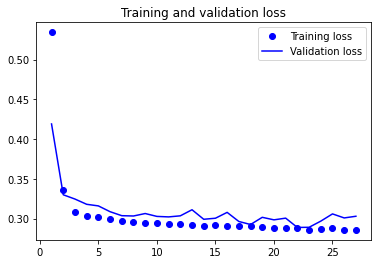

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The fully connected baseline performs better than the commonsense model. The best validation MAE is around 0.288 which translates to $2.20^{\circ}$ degree celcius


In [ ]:
mae_fullyconnected=model.evaluate(val_gen, steps=val_steps)
val['T (degC)'].std(axis=0)*mae_fullyconnected

436/436 [==============================] - 1s 2ms/step - loss: 0.2888


2.208720751702966

## The first Recurrent Baseline
We can increase model capacity by adding more layers until we overfit and then regularize but the performance gain for the fully connected network is likely going to be small. This is because, as explained in the lectures, fully connected networks don't have memory and are not optimized for sequence data. the fully connected layer first flattened the timeseries which removed the notion of time from the input data.

Let’s instead look at the data as what it is: a sequence, where causality and order matter. You’ll try a recurrent-sequence processing model it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.

In the following code segment, we replace the first Dense Layer with a GRU (Gated Recurrent Unit) layer. The flatten layer is no longer needed because GRU requires a batch of 3D arrays of dimenson **[number of examples, look back time steps,features]** 



In [ ]:

model_recurrent=keras.Sequential(
    [
        layers.GRU(32),
        layers.Dense(1)
    ])
model_recurrent.compile(optimizer='Adam', loss='mae')

history = model_recurrent.fit(train_gen, steps_per_epoch=train_steps, epochs=50, validation_data=val_gen, validation_steps=val_steps, callbacks=[early_stopping])

Epoch 1/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.3161 - val_loss: 0.3319
Epoch 2/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2887 - val_loss: 0.2962
Epoch 3/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2827 - val_loss: 0.2857
Epoch 4/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2792 - val_loss: 0.2825
Epoch 5/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2767 - val_loss: 0.2810
Epoch 6/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2744 - val_loss: 0.2809
Epoch 7/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2725 - val_loss: 0.2796
Epoch 8/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2708 - val_loss: 0.2793
Epoch 9/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.2691 - val_loss: 0.2792
Epoch 10/50
1531/1531 [==============================] - 7s 5ms/step - loss: 0.267

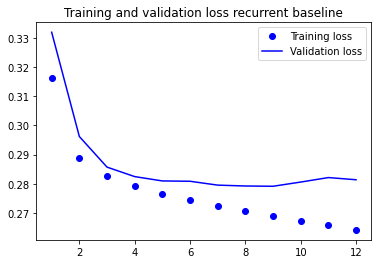

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss recurrent baseline')
plt.legend()
plt.show()

The result is better than the fully connected network. The best validation MAE is 0.2796 which translates to about $2.13^{\circ}$ .However, the model starts overfitting after the third epoch.

In [ ]:
mae_recurreent_baseline=model_recurrent.evaluate(val_gen, steps=val_steps)
val['T (degC)'].std(axis=0)*mae_recurreent_baseline

436/436 [==============================] - 1s 3ms/step - loss: 0.2796


2.1383074703337903

## Battling Overfitting
We can add drop out and weight decay to help reduce overfitting. in pratice, it is best if you try one technique at a time to see which one causes your model to improve but for the sake of brevity I will try both in the following model. 

You are already familiar with dropout as a classic technique for fighting overfitting in dense layers. The standard dropout randomly drops some neurons in each layer by setting their outputs to zero. In a recurrent layer, the drop out can also be applied in the temporal direcion between time steps, that is, we can randomly drop the recurrent connections by setting the hidden states at some time steps to zero. This is known as *recurrent dropout*. 

It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, [Gal et. al. ](https://arxiv.org/abs/1512.05287) showed that the proper way to use dropout with a recurrent layer is to apply the same dropout mask ( that is the same patten of dropping neurons) in each time step. You can find more details about recurrent drop out in Gal's paper.

Every recurrent layer in Keras has two dropout-related
arguments: <code>dropout</code>, a float specifying the dropout rate for input units of the layer,and <code>recurrent_dropout</code>, specifying the dropout rate along the temporal dimension. Let’s add dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting.

Recall from our regularization lectures that another technique we have in our toolbox for fighting against overfitting is weight decay. We apply the weight decay penalty to the input weights  via <code>kernel_regularizer</code> or we can apply it to the recurrent weights via <code>recurrent_kernel_regularizer</code>
s.

This model runs much slower compared to the previous model. This is because after adding the recurrent_dropout, the model no longer meets the criteria to run on CUDNN kernel which is GPU-accelerated library of primitives for deep neural networks (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) for details)



In [ ]:

model_regularized=keras.Sequential(
    [
        layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.001), recurrent_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
model_regularized.compile(optimizer='Adam', loss='mae')


history = model_regularized.fit(train_gen, steps_per_epoch=train_steps, epochs=20, validation_data=val_gen, validation_steps=val_steps, callbacks=[early_stopping])

Epoch 1/20
1531/1531 [==============================] - 125s 82ms/step - loss: 0.3660 - val_loss: 0.3404
Epoch 2/20
1531/1531 [==============================] - 123s 81ms/step - loss: 0.3244 - val_loss: 0.3166
Epoch 3/20
1531/1531 [==============================] - 123s 81ms/step - loss: 0.3141 - val_loss: 0.3084
Epoch 4/20
1531/1531 [==============================] - 124s 81ms/step - loss: 0.3091 - val_loss: 0.3081
Epoch 5/20
1531/1531 [==============================] - 124s 81ms/step - loss: 0.3066 - val_loss: 0.3055
Epoch 6/20
1531/1531 [==============================] - 124s 81ms/step - loss: 0.3045 - val_loss: 0.3084
Epoch 7/20
1531/1531 [==============================] - 121s 79ms/step - loss: 0.3025 - val_loss: 0.3059
Epoch 8/20
1531/1531 [==============================] - 118s 77ms/step - loss: 0.3014 - val_loss: 0.3028
Epoch 9/20
1531/1531 [==============================] - 118s 77ms/step - loss: 0.3007 - val_loss: 0.3013
Epoch 10/20
1531/1531 [==============================] 

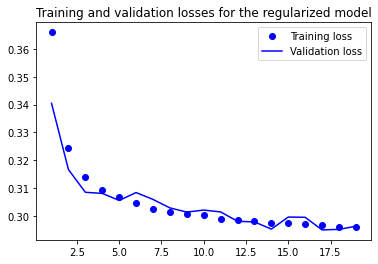

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses for the regularized model')
plt.legend()
plt.show()

The learning curves show that the model no longer overfits. However, its validation performance is worse than the unregularized model. 

models that use dropout regularization typically take longer to coverge so Let's resume the training for a few more epochs. 

It is a common practice to stop the training once the learning slows down and decrease the learning rate by an order of magnitude before resuming the training again.

To do this, you can recompile the model with the reduced learning rate and call mode.fit to resume the training. The parameter <code>initial_epoch=20</code> means to resume the training after the 20th epoch (the last epoch after which the training has been stopped)

In [ ]:
model_regularized.compile(optimizer=Adam(learning_rate=1e-4), loss='mae')

history = model_regularized.fit(train_gen, steps_per_epoch=train_steps, epochs=40, initial_epoch=20,
                                validation_data=val_gen, validation_steps=val_steps)

Epoch 21/40
1531/1531 [==============================] - 123s 80ms/step - loss: 0.2882 - val_loss: 0.2869
Epoch 22/40
1531/1531 [==============================] - 122s 80ms/step - loss: 0.2877 - val_loss: 0.2863
Epoch 23/40
1531/1531 [==============================] - 122s 80ms/step - loss: 0.2867 - val_loss: 0.2865
Epoch 24/40
1531/1531 [==============================] - 124s 81ms/step - loss: 0.2870 - val_loss: 0.2861
Epoch 25/40
1531/1531 [==============================] - 122s 79ms/step - loss: 0.2866 - val_loss: 0.2860
Epoch 26/40
1531/1531 [==============================] - 122s 80ms/step - loss: 0.2870 - val_loss: 0.2853
Epoch 27/40
1531/1531 [==============================] - 121s 79ms/step - loss: 0.2862 - val_loss: 0.2859
Epoch 28/40
1531/1531 [==============================] - 121s 79ms/step - loss: 0.2864 - val_loss: 0.2856
Epoch 29/40
1531/1531 [==============================] - 122s 80ms/step - loss: 0.2858 - val_loss: 0.2857
Epoch 30/40
1531/1531 [=======================

That reduced the validaiton error but the final validation loss is still slightly higher than the unregularized model and mae is about $2.17^\circ$ degree. Nevertheless, this model does not overfit and generalizes better than the unregularized model and the evaluation scores are more stable. You can further try to improve the model by tuning the hyperparameters such as the numeber of neurons in the recurrent layer, the learning rate and the drop out and weight decay rates. 


In [ ]:
mae_recurrent_regularized=model_regularized.evaluate(val_gen, steps=val_steps)
val['T (degC)'].std(axis=0)*mae_recurrent_regularized

436/436 [==============================] - 4s 8ms/step - loss: 0.2841


2.173445837579321

## Stacking recurrent layers

Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity of the network. Recall the description of
the universal machine-learning workflow: it’s generally a good idea to increase the capacity of your network until overfitting becomes the primary obstacle (a
you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity.
Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build
more-powerful recurrent networks: for instance, what currently powers the Google Translate algorithm is a stack of seven large LSTM layers—that’s huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at
the last timestep. This is done by specifying <code>return_sequences=True</code> .

In [ ]:

train_steps= int((train_df.shape[0]-LOOKBACK-OFFSET)/BATCH_SIZE)
val_steps= int((val_df.shape[0]-LOOKBACK-OFFSET)/BATCH_SIZE)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, restore_best_weights=True)

model=keras.Sequential(
    [
        layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, kernel_regularizer=regularizers.l2(0.001), 
                   recurrent_regularizer=regularizers.l2(0.001), return_sequences=True),
        layers.GRU(64, dropout=0.1, recurrent_dropout=0.5, kernel_regularizer=regularizers.l2(0.001), 
                   recurrent_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
model.compile(optimizer='Adam', loss='mae')


history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=30, validation_data=val_gen, validation_steps=val_steps, callbacks=[early_stopping])

Epoch 1/30
1531/1531 [==============================] - 230s 150ms/step - loss: 0.3945 - val_loss: 0.3369
Epoch 2/30
1531/1531 [==============================] - 229s 149ms/step - loss: 0.3411 - val_loss: 0.3161
Epoch 3/30
1531/1531 [==============================] - 232s 152ms/step - loss: 0.3272 - val_loss: 0.3133
Epoch 4/30
1531/1531 [==============================] - 233s 152ms/step - loss: 0.3207 - val_loss: 0.3074
Epoch 5/30
1531/1531 [==============================] - 234s 153ms/step - loss: 0.3160 - val_loss: 0.3066
Epoch 6/30
1531/1531 [==============================] - 234s 153ms/step - loss: 0.3137 - val_loss: 0.3042
Epoch 7/30
1531/1531 [==============================] - 239s 156ms/step - loss: 0.3121 - val_loss: 0.3025
Epoch 8/30
1531/1531 [==============================] - 237s 155ms/step - loss: 0.3108 - val_loss: 0.3008
Epoch 9/30
1531/1531 [==============================] - 237s 155ms/step - loss: 0.3104 - val_loss: 0.2999
Epoch 10/30
1531/1531 [=======================

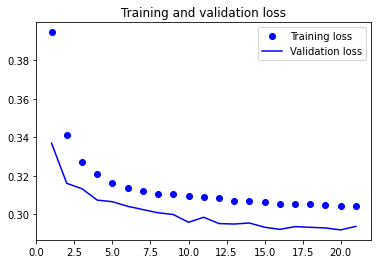

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

 Overall it appears that stacking more recurrent layers ddid not help much on this dataset.

## Evaluating the model on the test set
Let's evaluate our best model ( the regularized recurrent model) on the test data. The mae of the model on the test data is $1.94^\circ$ degree. This means on average the model was able to predict the temprature 24 hours in the future with $1.94^\circ$ error.


In [ ]:
test_steps= int((test_df.shape[0]-LOOKBACK-OFFSET)/BATCH_SIZE)
mae_test=model_regularized.evaluate(test_gen, steps=test_steps)
test['T (degC)'].std(axis=0)*mae_test

217/217 [==============================] - 2s 8ms/step - loss: 0.2477


1.9439480412958081